In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('played_out.csv', index_col=0)

In [3]:
# factors (levels) : age (3), gender (2), first_genre (5)
# 3 x 2 x 5 = 30 combinations

# Unique users 
age_gender_first_genre = df.groupby(['age', 'gender', 'first_genre']).agg({'user':pd.Series.nunique}).reset_index()

# sort values by first_genre, age, gender
age_gender_first_genre = age_gender_first_genre.sort_values(by=['first_genre', 'age', 'gender']).reset_index(drop=True)
age_gender_first_genre

,age,gender,first_genre,user
0,20,F,1,3
1,20,M,1,3
2,40,F,1,3
3,40,M,1,3
4,60,F,1,2
5,60,M,1,3
6,20,F,2,3
7,20,M,2,3
8,40,F,2,3
9,40,M,2,3


In [4]:
print(f"Total number of unique users: {df['user'].nunique()}") # Total number of unique users
# 89 users in total, each with a playlist of around 50 songs ~ 4450 rows (songs played)

print(f"Total number of unique tracks: {df['track.id'].nunique()}") # Total number of 682 unique songs
# 682 unique songs in total played in 4450 songs played
# Implies that many songs were played multiple times across different users

# make a vector of expected songs par first genre ie. 17 x 50 = 850, 18 x 50 = 900 etc.
# Assuming each user has a playlist of around 50 songs
expected_unique_songs_per_genre = {}
for genre in df['first_genre'].unique():
    genre = int(genre)  # Convert genre to integer
    users_in_genre = df[df['first_genre'] == genre]['user'].nunique()
    expected_unique_songs_per_genre[genre] = users_in_genre * 50
   

## Group the number of unique tracks played by first_genre
tracks_per_genre = df.groupby(['first_genre']).agg({'track.id':pd.Series.nunique, 
                                                   'user':pd.Series.nunique, 
                                                   'track.name':pd.Series.nunique}).reset_index().rename(
                                                       columns={'track.id':'unique_tracks', 
                                                                'user':'num_users',
                                                                'track.name':'unique_track_names'})

tracks_per_genre['expected_unique_tracks'] = tracks_per_genre['first_genre'].map(
    expected_unique_songs_per_genre)
tracks_per_genre['coverage_percentage'] = (
    tracks_per_genre['unique_tracks'] / tracks_per_genre['expected_unique_tracks']) * 100

# Order the columns
tracks_per_genre = tracks_per_genre[['first_genre', 'num_users', 'unique_tracks', 'unique_track_names',
                                     'expected_unique_tracks', 'coverage_percentage']]


# last row is totoal across all genres
total_row = pd.DataFrame({
    'first_genre': ['Total'],
    'num_users': [tracks_per_genre['num_users'].sum()],
    'unique_tracks': [tracks_per_genre['unique_tracks'].sum()],
    'unique_track_names': [tracks_per_genre['unique_track_names'].sum()],
    'expected_unique_tracks': [tracks_per_genre['expected_unique_tracks'].sum()],
    'coverage_percentage': [(tracks_per_genre['unique_tracks'].sum() / 
                             tracks_per_genre['expected_unique_tracks'].sum()) * 100]
})
tracks_per_genre = pd.concat([tracks_per_genre, total_row], ignore_index=True)
tracks_per_genre

Total number of unique users: 89
Total number of unique tracks: 682


,first_genre,num_users,unique_tracks,unique_track_names,expected_unique_tracks,coverage_percentage
0,1,17,131,129,850,15.411765
1,2,18,159,158,900,17.666667
2,3,18,176,172,900,19.555556
3,4,18,138,137,900,15.333333
4,5,18,167,164,900,18.555556
5,Total,89,771,760,4450,17.325843


## Missing Values

In [5]:
# Missing values in dataset
na = df.isna().sum().reset_index().rename(columns={'index':'Feature', 0:'NA'})
na['total'] = 4572
na['% Missing'] = round(100*na['NA']/na['total'], 2)
na = na[na['NA'] > 0]
na

,Feature,NA,total,% Missing
15,accousticness,273,4572,5.97
16,danceability,273,4572,5.97
17,energy,273,4572,5.97
18,instrumentalness,273,4572,5.97
19,key,273,4572,5.97
20,liveness,273,4572,5.97
21,loudness,273,4572,5.97
22,mode,273,4572,5.97
23,speechiness,273,4572,5.97
24,tempo,273,4572,5.97


In [6]:
tracks = df[['track.id', 'accousticness']].drop_duplicates()
tracks['Feature value'] = np.where(tracks['accousticness'].isna(), 'NA', 'OK')
tracks.groupby('Feature value').agg({'track.id':'count'}).reset_index().rename(columns={'track.id':'# of songs'})

,Feature value,# of songs
0,NA,49
1,OK,633


In [7]:
genre_df = df[['user', 'first_genre', 'position', 'track.id', 'accousticness']].drop_duplicates()
genre_df = genre_df.sort_values(['user', 'position']).reset_index(drop=True)

genre_na = genre_df[genre_df['accousticness'].isna()]
genre_na_summary = genre_na.groupby('first_genre').agg({'track.id': 'nunique'}).reset_index()
genre_na_summary = genre_na_summary.rename(columns={'track.id': 'Songs with missing audio features'})

pos_0_na = genre_df[(genre_df['accousticness'].isna()) & (genre_df['position'] == 0)]
pos_0_summary = pos_0_na.groupby('first_genre').agg({'track.id': 'nunique'}).reset_index()
pos_0_summary = pos_0_summary.rename(columns={'track.id': 'Missing features at position 0'})

genre_na = genre_na_summary.merge(pos_0_summary, on='first_genre', how='left')

genre_na['Missing features at position 0'] = genre_na['Missing features at position 0'].fillna(0).astype(int)


# add last row as total of all genres
total_row = pd.DataFrame({
    'first_genre': ['Total'],
    'Songs with missing audio features': [genre_na['Songs with missing audio features'].sum()],
    'Missing features at position 0': [genre_na['Missing features at position 0'].sum()]
})
genre_na = pd.concat([genre_na, total_row], ignore_index=True)
genre_na

,first_genre,Songs with missing audio features,Missing features at position 0
0,1,11,0
1,2,15,1
2,3,18,0
3,4,5,0
4,5,10,1
5,Total,59,2


In [8]:
# join two dataframes on first_genre
tracks_per_genre = tracks_per_genre.merge(genre_na, on='first_genre', how='left')

# rearrange the columns
tracks_per_genre = tracks_per_genre[['first_genre', 'num_users', 'unique_tracks', 'unique_track_names',
                                     'expected_unique_tracks', 'coverage_percentage',
                                     'Songs with missing audio features', 'Missing features at position 0']]
tracks_per_genre

,first_genre,num_users,unique_tracks,unique_track_names,expected_unique_tracks,coverage_percentage,Songs with missing audio features,Missing features at position 0
0,1,17,131,129,850,15.411765,11,0
1,2,18,159,158,900,17.666667,15,1
2,3,18,176,172,900,19.555556,18,0
3,4,18,138,137,900,15.333333,5,0
4,5,18,167,164,900,18.555556,10,1
5,Total,89,771,760,4450,17.325843,59,2


In [17]:
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-Based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}

list(genre_mapping.values())[:3]

['Pop & Mainstream', 'Urban & Contemporary', 'Electronic & Beat-Based']

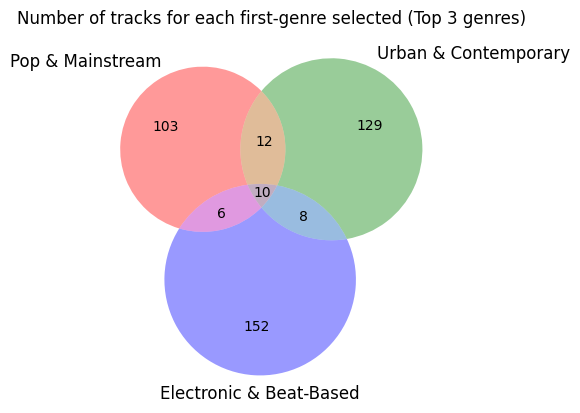

In [18]:
# Song overlap between genres
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

genre_1 = set(df[df['first_genre'] == 1]['track.id'].unique())
genre_2 = set(df[df['first_genre'] == 2]['track.id'].unique())
genre_3 = set(df[df['first_genre'] == 3]['track.id'].unique())

venn3([genre_1, genre_2, genre_3], list(genre_mapping.values())[:3])

plt.title("Number of tracks for each first-genre selected (Top 3 genres)")
plt.show()

In [ ]:
from upsetplot import from_contents, plot
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings from upsetplot library
warnings.filterwarnings('ignore', category=FutureWarning)

# Source - https://stackoverflow.com/a
# Posted by astrofrog, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-28, License - CC BY-SA 4.0


genre_data = {
    'Pop & Mainstream': df[df['first_genre'] == 1]['track.id'].unique(),
    'Urban & Contemporary': df[df['first_genre'] == 2]['track.id'].unique(),
    'Electronic & Beat-based': df[df['first_genre'] == 3]['track.id'].unique(),
    'Rock & Heavy': df[df['first_genre'] == 4]['track.id'].unique(),
    'Roots, Jazz & Classical Traditions': df[df['first_genre'] == 5]['track.id'].unique()
}

upset_data = from_contents(genre_data)
upset_data


id
Pop & Mainstream Urban & Contemporary Electronic & Beat-based Rock & Heavy Roots, Jazz & Classical Traditions                        
True             False                False                   False        False                               1lK5iIMKifrxERzS3iimJH
                 True                 True                    False        False                               4Dvkj6JhhA12EX05fT7y2e
                 False                False                   False        False                               3QaPy1KgI7nu9FJEQUgn6h
                 True                 False                   False        False                               5QO79kh1waicV47BqGRL3g
                 False                False                   False        False                               4RvWPyQ5RL0ao9LPZeSouE
...                                                                                                                               ...
False            False                False                   False        True                                3Vji5BYcceyvEOBNCHsVrx
                                                                           True                                2vCGb0Sr5ismOhXPliKLRW
                                                                           True                                1FdulvpRiLgkseCz7RrNOR
                                                                           True                                0KhT24AgBxl4GjUB4Yz5fZ
                                                                           True                                4jep6dMPP0z7HrN375InoL

[682 rows x 1 columns]

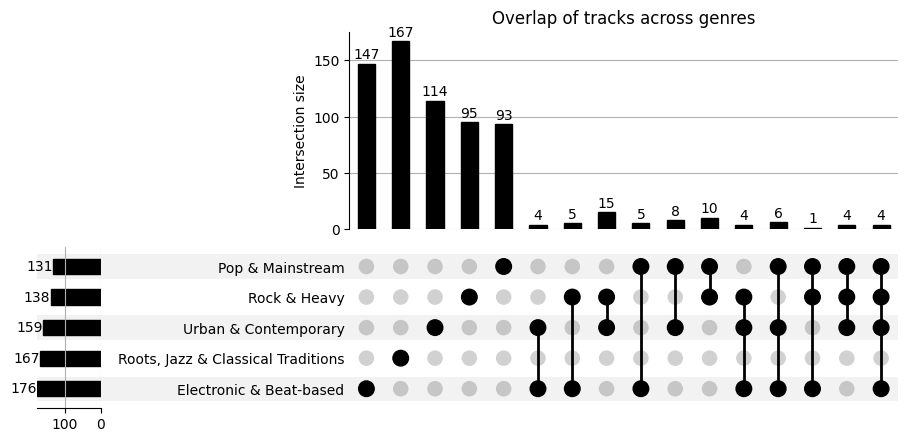

In [ ]:
plot(upset_data, subset_size='count', show_counts=True)
plt.title("Overlap of tracks across genres")
plt.show()


## Note : Total Partitions : Sterling number of 2nd Kind
# Left Bottom : Songs per Genre (repitition is allowed)
# Dots alone : Set containg elements belongs to them alone
# Segments : Interactions of the sets
# The empty intersections are not plotted.

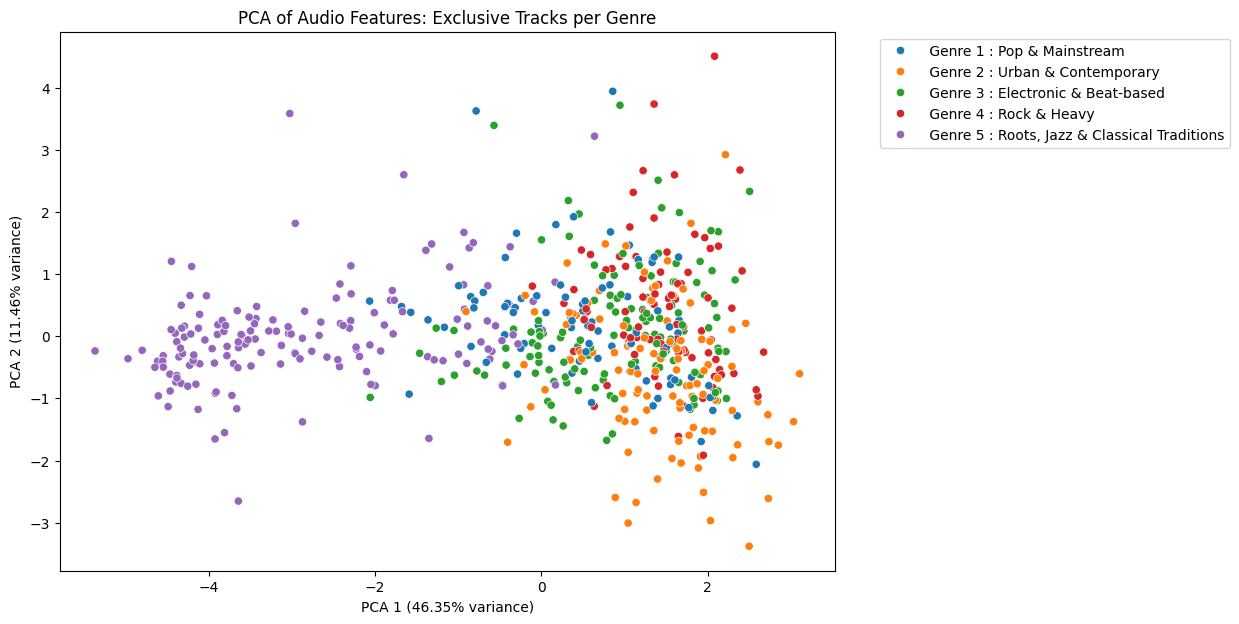

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define features for PCA
audio_features = [
    'accousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# 1. Identify "Exclusive" tracks (those that belong to only one genre)
# We count how many unique genres each track ID is associated with
track_counts = df.groupby('track.id')['first_genre'].nunique()
exclusive_ids = track_counts[track_counts == 1].index

# Extract audio features for exclusive tracks from df
exclusive_df = df[df['track.id'].isin(exclusive_ids)][['track.id', 'first_genre'] + audio_features].drop_duplicates()

# Drop rows with missing values in these features
exclusive_df = exclusive_df.dropna(subset=audio_features)

# 3. Normalize the data
# Since features like 'tempo' (0-250) and 'loudness' (-60 to 0) are on different scales, 
# normalization is required for PCA to work correctly.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(exclusive_df[audio_features])

# 4. Perform PCA (Reduce to 2 components for 2D visualization)
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_features)

exclusive_df['PCA1'] = pca_results[:, 0]
exclusive_df['PCA2'] = pca_results[:, 1]
exclusive_df['PCA3'] = pca_results[:, 2]

# 5. Mapping genre IDs to names for the legend
# Adjust the mapping based on your data structure
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}
# Create display mapping with ID included
genre_display_mapping = {k: f" Genre {k} : {v}" for k, v in genre_mapping.items()}
exclusive_df['Genre Name'] = exclusive_df['first_genre'].map(genre_display_mapping)

# 6. Visualize the clusters
plt.figure(figsize=(10, 7))
# Define genre order for legend
genre_order = sorted(exclusive_df['first_genre'].unique())
genre_display_order = [genre_display_mapping[g] for g in genre_order]
sns.scatterplot(
    data=exclusive_df, 
    x='PCA1', y='PCA2', 
    hue='Genre Name', 
    palette='tab10',
    hue_order=genre_display_order
)

plt.title("PCA of Audio Features: Exclusive Tracks per Genre")
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")

plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")# plt.grid(True, linestyle='--', alpha=0.5)plt.show()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Total variance explained by 3 components: 68.51%


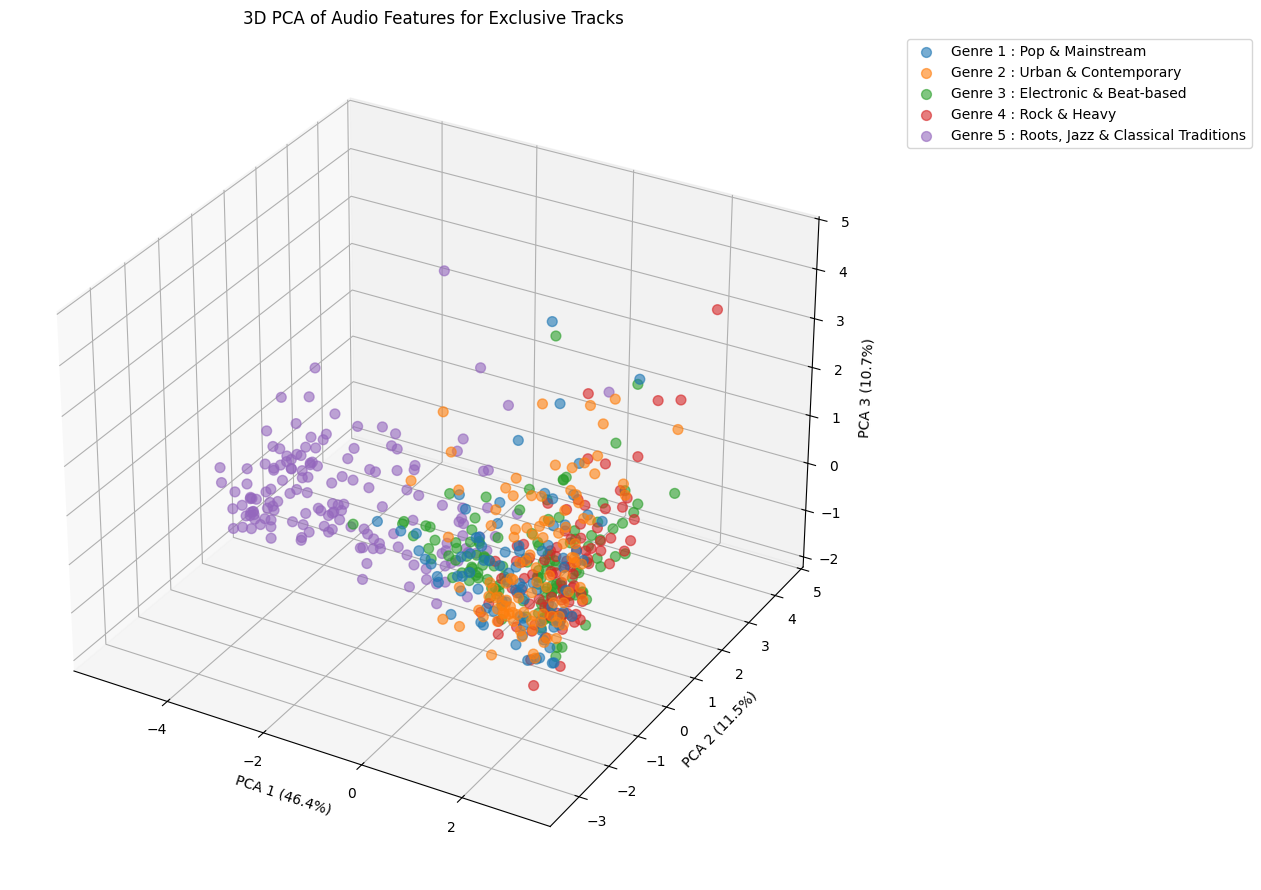

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Identify "Exclusive" tracks (those belonging to only one genre)
track_counts = df.groupby('track.id')['first_genre'].nunique()
exclusive_ids = track_counts[track_counts == 1].index

# Define audio features
audio_features = [
    'accousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Extract audio features for exclusive tracks from df
exclusive_df = df[df['track.id'].isin(exclusive_ids)][['track.id', 'first_genre'] + audio_features].drop_duplicates()
exclusive_df = exclusive_df.dropna(subset=audio_features)

# 2. Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(exclusive_df[audio_features])

# 3. Perform PCA with 3 components
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_features)

exclusive_df['PCA1'] = pca_results[:, 0]
exclusive_df['PCA2'] = pca_results[:, 1]
exclusive_df['PCA3'] = pca_results[:, 2]

# 4. Define Genre Mapping (ensure these match your actual data)
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical Traditions'
}
# Create display mapping with ID included
genre_display_mapping = {k: f"Genre {k} : {v}" for k, v in genre_mapping.items()}
exclusive_df['Genre Name'] = exclusive_df['first_genre'].map(genre_display_mapping)

# 5. Build the 3D Scatter Plot (Corrected Version)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') # Simple and direct

# Iterate through genres in order (1 to 5)
for genre_id in sorted(exclusive_df['first_genre'].unique()):
    genre_name = genre_display_mapping[genre_id]
    subset = exclusive_df[exclusive_df['first_genre'] == genre_id]
    ax.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], 
               label=genre_name, alpha=0.6, s=50)

# Labeling axes with the variance explained
var_exp = pca.explained_variance_ratio_
ax.set_xlabel(f'PCA 1 ({var_exp[0]:.1%})')
ax.set_ylabel(f'PCA 2 ({var_exp[1]:.1%})')
ax.set_zlabel(f'PCA 3 ({var_exp[2]:.1%})')

print(f"Total variance explained by 3 components: {sum(var_exp):.2%}")

plt.title("3D PCA of Audio Features for Exclusive Tracks")# Print total variance for your analysis

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()